In [1]:
import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from RFSoC_Daq import RFSoC_Daq
from Biquad import Biquad
from SimBiquad import SimBiquad
from Biquad_Daq import Biquad_Daq
from Filter import Filter

from Waveforms.Waveform import Waveform

In [2]:
daq = Biquad_Daq()
sim = SimBiquad()
filter = Filter()

DEBUG:RFSoC_Daq:Asked to load overlay at /home/xilinx/python/zcumts.py
DEBUG:RFSoC_Daq:Adding directory /home/xilinx/python to module search path
DEBUG:RFSoC_Daq:Changing directory to /home/xilinx/python
DEBUG:RFSoC_Daq:Going to try to import zcumts
DEBUG:RFSoC_Daq:Found Overlay class Overlay from module pynq.overlay
DEBUG:RFSoC_Daq:Found RFSoC overlay zcuMTS


Turning on SYNC
Turning off SYNC


DEBUG:RFSoC_Daq:Created RFSoC device
DEBUG:RFSoC_Daq:Restoring original module search path
DEBUG:RFSoC_Daq:Going back to original directory /home/xilinx/rfsoc-pydaq/Biquad/Notebooks


In [12]:
filter.calc_params(375)

zf = True
pf = True
pi = True
ao = True

In [4]:
import pynq

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [5]:
def update_plot():
    # daq.reset()
    
    daq.update_params(**filter.get_params())
    daq.quantise_coeffs()
    
    daq.generate_waveforms()
    
    sim.update_params(**filter.get_params())
    sim.data = daq.adcBuffer[0] >> 4
    sim.quantise_coeffs()
    
    sim.run_zeroFIR(quant=zf)
    sim.run_poleFIR(quant=pf)
    sim.run_poleIIR(quant=pi)
    
    daq_input = daq.extract_raw()
    daq_output = daq.extract_biquad()
    sim_output = sim.extract_biquad(quant=ao)
    diff_output = Waveform(daq_output.waveform - sim_output.waveform)
    
    fig, (axI, axB, axS, axR) = plt.subplots(4, 1, figsize=(35, 15))
    
    daq_input.plotWaveform(axI, title="Raw ADC224_T0_CH0")
    
    daq_output.plotWaveform(axB, title="Biquaded ADC224_T0_CH0")
    
    sim_output.plotWaveform(axS, title="Simulated Biquad")
    
    diff_output.plotWaveform(axR, title="Difference")
    
    plt.show()
    print(filter)

In [13]:
A_slider = widgets.FloatSlider(min=-4, max=4, step=0.05, value=filter.A, description='A:', continuous_update=False)
P_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=filter.P, description='P:', continuous_update=False)
Zero_slider = widgets.FloatSlider(min=200, max=1200, step=5, value=filter.fz, description='Zero:', continuous_update=False)
Pole_slider = widgets.FloatSlider(min=1, max=1500, step=5, value=filter.fp, description='Pole:', continuous_update=False)

plot_output = widgets.Output()

# def update_plot():
#     with plot_output:
#         plot_output.clear_output(wait=True)
#        print(f"Plotting with: A={filter.A}, P={filter.P}, Zero={filter.fz}, Pole={filter.fp}")

def update_params(_=None):
    with plot_output:
        plot_output.clear_output(wait=True)
        filter.fz = Zero_slider.value
        filter.A = A_slider.value
        filter.P = P_slider.value
        filter.fp = Pole_slider.value
        update_plot()

def update(change):
    with plot_output:
        plot_output.clear_output(wait=True)
        if change['owner'] == Zero_slider:
            filter.fz = Zero_slider.value
            A_slider.value = filter.A
            P_slider.value = filter.P
            Pole_slider.value = filter.fp
        update_plot()
        
update_button = widgets.Button(description="Update Plot")

update_button.on_click(update_params)
        
Zero_slider.observe(update, names='value')

# Layout
slider_box = widgets.HBox([A_slider, P_slider, Zero_slider, Pole_slider, update_button])
ui = widgets.VBox([slider_box, plot_output])

# Display
display(ui)

# Initial plot
update_params()

In [7]:
zf = False
pf = True
pi = True

In [8]:
p2p_arr = []
err_arr = []

In [9]:
iterations = 10

for _ in range(iterations):
    daq.update_waveforms()
    
    sim.data = daq.adcBuffer[0] >> 4
    sim.run_zeroFIR(quant=zf)
    sim.run_poleFIR(quant=pf)
    sim.run_poleIIR(quant=pi)
    
    daq_input = daq.extract_raw()
    daq_output = daq.extract_biquad()
    sim_output = sim.extract_biquad(quant=False)
    diff_output = Waveform(daq_output.waveform - sim_output.waveform)
    
    p2p_arr.append(daq_input.calc_PtP())
    err_arr.append(2*diff_output.calc_rms())

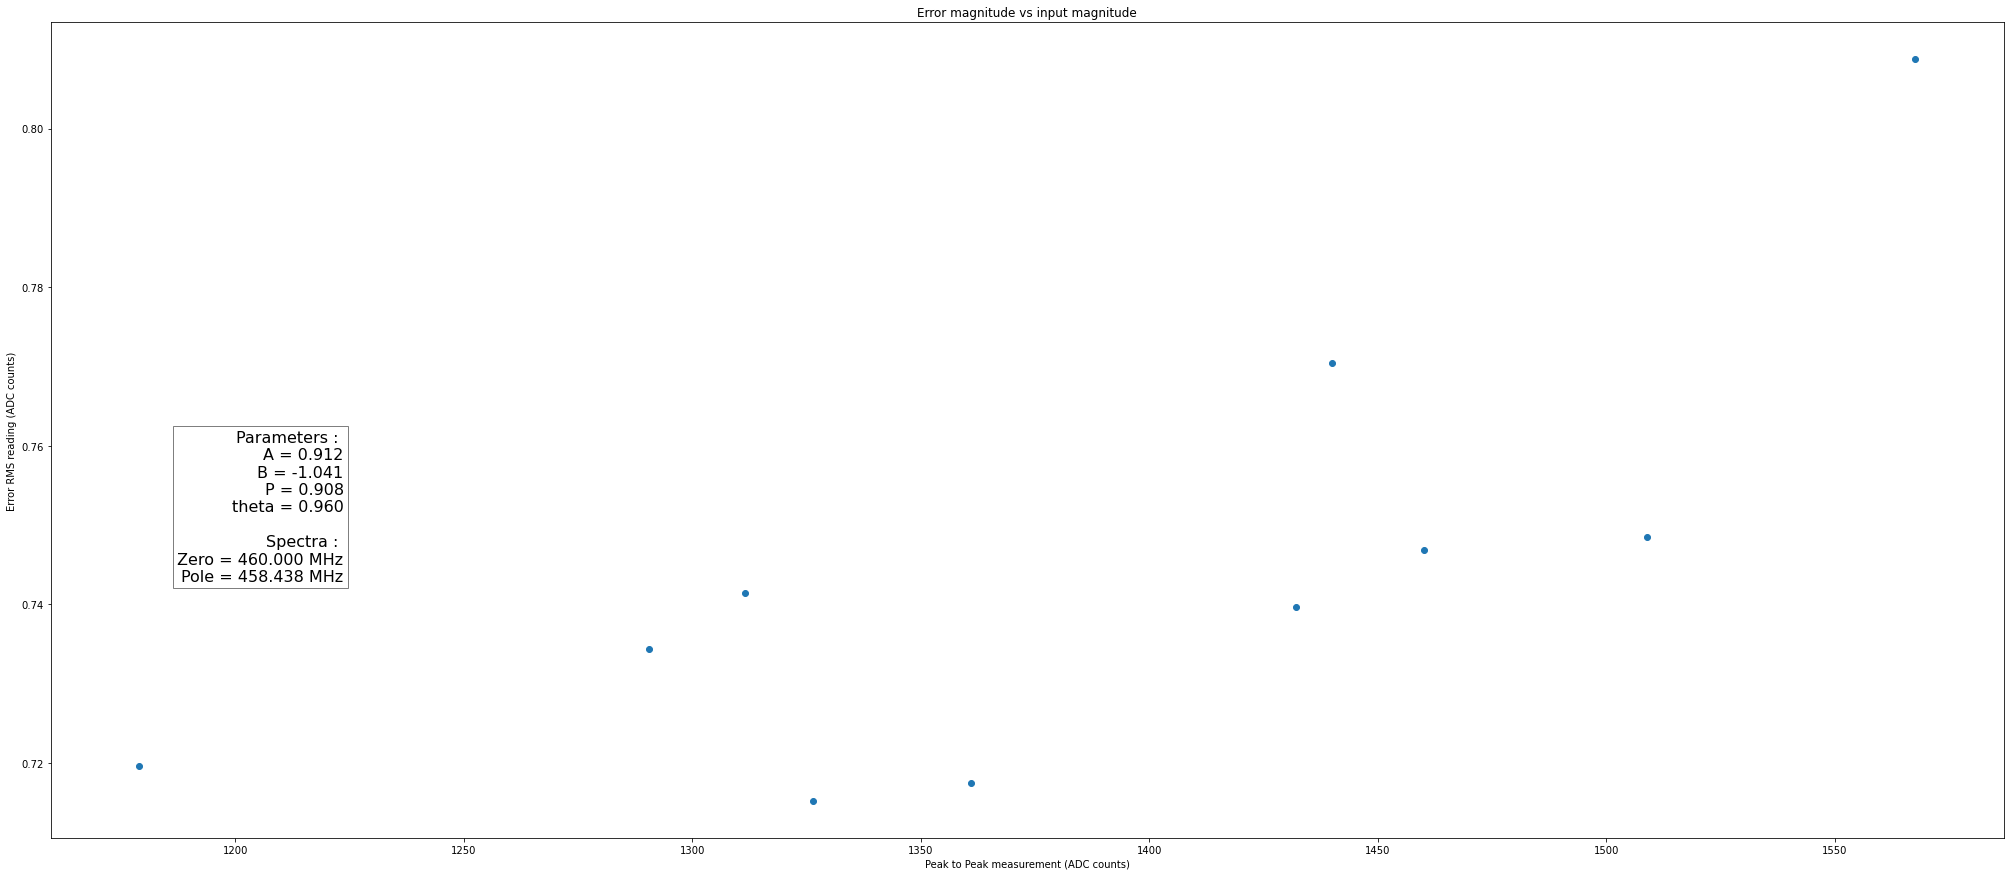

In [10]:
fig, ax = plt.subplots(figsize=(35, 15))

ax.scatter(p2p_arr, err_arr)
ax.set_xlabel("Peak to Peak measurement (ADC counts)")
ax.set_ylabel("Error RMS reading (ADC counts)")

ax.set_title("Error magnitude vs input magnitude")

ax.text(0.15, 0.50, filter.__str__(), verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=16)

plt.show()

In [11]:
filter.calc_params(460)
print(filter)

Parameters : 
A = 0.912
B = -1.041
P = 0.908
theta = 0.960

Spectra : 
Zero = 460.000 MHz
Pole = 458.438 MHz
